# Selecting and Comparing Genes with GSForge


Our goal in examining RNA-seq data sets often reduces to "feature selection" -- to borrow a term from machine learning.
Examining the count data should give us an idea of which genes correlate (by a given measure) with a phenotype of intrest.
We can then examine that 'selected' set more closely and form biological or chemical hypothesis that explain the expression-phenotype link. Unfortunately there is not a gold standard measure to preform this selection, and practicing researchers must juggle a number of different methods and results.


---

**Enter `GSForge`**: 
A tool that helps collate and compare gene 'selection' resuls from a given method.
Here we present a brief analysis of a *oryza sativa* cultivar set[1], with the explicit purpose of demonstrating `GSForge`.

---


## Contents

1. Create an Annotated Gene Expression Matrix
    + The `AnnotatedGEM` object stores gene expression data alongside sample annotations.
    + Save normalizations or transforms.
2. Select genes / features / tags
    + Using an R script: `edgeR`.
    + Using the Boruta algorithm with a random forest model from `sklearn`.
    + From the literature.
3. Compare results
    + Set operations on selection indices.
    + Compare and rank between sets.
    + Compare and rank within sets.
4. Next Steps
    + Create a comparative specifiaction.
    + Visualize results.

---

In [1]:
from os import  environ
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr

import patsy
import GSForge as gsf
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import quantile_transform
from sklearn import model_selection
from sklearn import linear_model
from scipy import stats
import umap
import umap.plot

import matplotlib.pyplot as plt
import colorcet as cc
import seaborn as sns
import holoviews as hv
hv.extension('matplotlib')


# Declare paths.
OSF_PATH = Path(environ.get("GSFORGE_DEMO_DATA", default="~/GSForge_demo_data/osfstorage/oryza_sativa")).expanduser()
RAW_COUNT_PATH = OSF_PATH.joinpath("GEMmakerGEMs", "rice_heat_drought.GEM.raw.txt")
HYDRO_LABEL_PATH = OSF_PATH.joinpath("GEMmakerGEMs", "raw_annotation_data", "PRJNA301554.hydroponic.annotations.txt")
SI_FILE_1_PATH = OSF_PATH.joinpath('GEMmakerGEMs', 'raw_annotation_data', 'TPC2016-00158-LSBR2_Supplemental_File_1.csv')
# Output paths.
TOUR_DGE = OSF_PATH.joinpath("GeneSetCollections", "tour_DGE")
TOUR_BORUTA = OSF_PATH.joinpath("GeneSetCollections", "tour_boruta")
LIT_DGE_GSC = OSF_PATH.joinpath("GeneSetCollections", "literature", "DGE")
LIT_TF = OSF_PATH.joinpath("GeneSetCollections", "literature", "TF")

/home/tyler/anaconda3/envs/gsfenv/lib/python3.7/site-packages/holoviews/plotting/mpl/__init__.py:220: UserWarning: Trying to register the cmap 'fire' which already exists.
  register_cmap("fire", cmap=fire_cmap)


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

In [2]:
import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri
%load_ext rpy2.ipython
pandas2ri.activate()
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR) # Supresses verbose R output.

In [3]:
%%R
library("edgeR")

## 1. Create an Annotated Gene Expression Matrix

The `AnnotatedGEM` contains our expression matrix and any annotations that can be sample or gene indexed.
This object can be created directly from `GEMmaker` output and (properly formatted) annotation matrixes.
See [this notebook](../walkthroughs/oryza_sativa/01-AnnotatedGEM_from_pandas) for detail.

Our [`GEMmaker` workflow](https://gemmaker.readthedocs.io/en/latest/) for the alignment and quantification presented here.

In [4]:
agem = gsf.AnnotatedGEM.from_files(
    count_path=RAW_COUNT_PATH,
    label_path=HYDRO_LABEL_PATH,
    # These are the default arguments passed to from_files,
    # to the individual calls to `pandas.read_csv`.
    count_kwargs=dict(index_col=0, sep="\t"),
    label_kwargs=dict(index_col=1, sep="\t"),
)
agem.data['time'] = agem.data['time'].to_series().str.split(' ', expand=True).iloc[:, 0].astype(int)
agem

<GSForge.AnnotatedGEM>
Name: AnnotatedGEM01619
Selected GEM Variable: 'counts'
    Gene   55986
    Sample 475

Under the hood this is a light-weight wrapper for the `xarray.DataSet` object, which does all of the heavy lifting.

In [5]:
agem.data

<xarray.Dataset>
Dimensions:             (Sample: 475, Gene: 55986)
Coordinates:
  * Sample              (Sample) object 'SRX1423934' ... 'SRX1424408'
  * Gene                (Gene) object 'LOC_Os06g05820' ... 'LOC_Os07g03418'
Data variables: (12/29)
    BioSample           (Sample) object 'SAMN04251848' ... 'SAMN04251607'
    LoadDate            (Sample) object '2015-11-20' ... '2015-11-19'
    MBases              (Sample) int64 4016 5202 4053 1166 ... 3098 3529 2922
    MBytes              (Sample) int64 2738 3652 2719 764 ... 1983 2370 1862
    Run                 (Sample) object 'SRR2931040' ... 'SRR2931514'
    SRA_Sample          (Sample) object 'SRS1156722' ... 'SRS1156251'
    ...                  ...
    Platform            (Sample) object 'ILLUMINA' 'ILLUMINA' ... 'ILLUMINA'
    ReleaseDate         (Sample) object '2016-01-04' ... '2016-01-04'
    SRA_Study           (Sample) object 'SRP065945' 'SRP065945' ... 'SRP065945'
    source_name         (Sample) object 'Rice leaf' 'Rice leaf' ... 'Rice leaf'
    tissue              (Sample) object 'leaf' 'leaf' 'leaf' ... 'leaf' 'leaf'
    counts              (Sample, Gene) int64 20 0 0 0 0 0 ... 0 52 335 0 666 0

### Add a Normalized or Transformed Count Matrix

The `AnnotatedGEM` object can hold more than one count matrix, so long as they share the same gene and sample coordinates.
Here we demonstrate adding a TPM normalized matrix as produced by `edgeR`.
This is more usefull for transforms that are computationally expensive, or that require data not easily stored in the `AnnotatedGEM` object.

We can then access a given count matrix by passing `count_variable='NAME'` to `get_gem_data()`.

In [6]:
counts, _ = gsf.get_gem_data(agem)
agem.data['qt_counts'] = xr.DataArray(
    quantile_transform(counts.values, output_distribution='normal', axis=1), 
    coords=counts.coords, 
    name='qt_counts')

The `xarray.DataSet` object is available as `.data`:

In [7]:
agem.data['qt_counts']

<xarray.DataArray 'qt_counts' (Sample: 475, Gene: 55986)>
array([[ 0.52930109, -5.19933758, -5.19933758, ..., -5.19933758,
         1.59769842, -5.19933758],
       [ 0.36687305, -5.19933758, -5.19933758, ..., -5.19933758,
         1.54592732, -5.19933758],
       [ 0.53074486, -5.19933758, -5.19933758, ..., -5.19933758,
         1.53361204, -5.19933758],
       ...,
       [ 0.4279759 , -5.19933758, -5.19933758, ..., -5.19933758,
         1.51246295, -5.19933758],
       [ 0.42248277, -5.19933758, -5.19933758, ..., -5.19933758,
         1.36271302, -5.19933758],
       [ 0.5642668 , -5.19933758, -5.19933758, ..., -5.19933758,
         1.74700661, -5.19933758]])
Coordinates:
  * Gene     (Gene) object 'LOC_Os06g05820' ... 'LOC_Os07g03418'
  * Sample   (Sample) object 'SRX1423934' 'SRX1423935' ... 'SRX1424408'

### Select Counts and Annotations using `get_gem_data()`

The `AnnotatedGEM` object (and the `GeneSetCollection`, introduced further down) can have data subsets pulled from them easily using the `get_gem_data()` interface.

Here we select and pass genes to [UMAP](https://umap-learn.readthedocs.io/en/latest/), a dimensional reduction technique we prefer over PCA, tSNE and others.

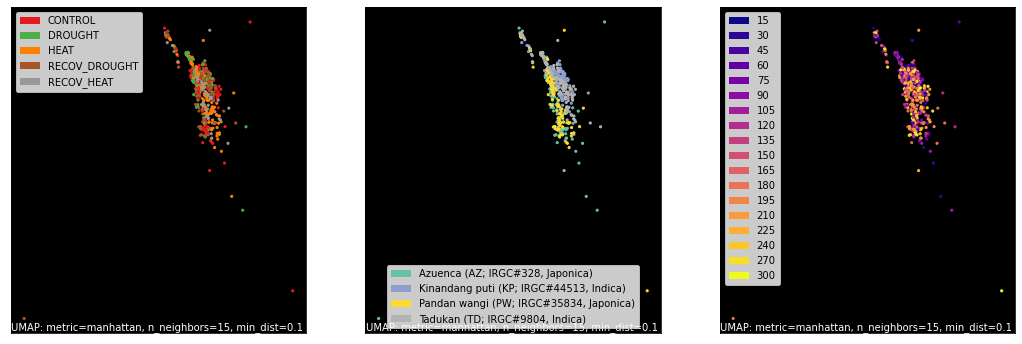

In [8]:
counts, labels = gsf.get_gem_data(agem, annotation_variables=['treatment', 'genotype', 'time'])
mapper = umap.UMAP(densmap=True, random_state=42, metric='manhattan').fit(counts.values)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
umap.plot.points(mapper, labels=labels['treatment'], background='black', ax=axes[0], color_key_cmap='Set1');
umap.plot.points(mapper, labels=labels['genotype'], background='black', ax=axes[1], color_key_cmap='Set2');
umap.plot.points(mapper, labels=labels['time'], background='black', ax=axes[2], color_key_cmap='plasma');

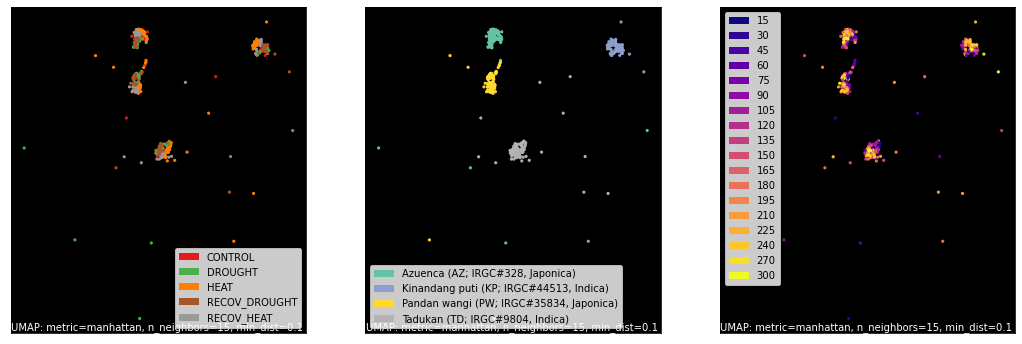

In [9]:
counts, labels = gsf.get_gem_data(agem, annotation_variables=['treatment', 'genotype', 'time'], count_variable='qt_counts')
mapper = umap.UMAP(densmap=True, random_state=42, metric='manhattan').fit(counts.values)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
umap.plot.points(mapper, labels=labels['treatment'], background='black', ax=axes[0], color_key_cmap='Set1');
umap.plot.points(mapper, labels=labels['genotype'], background='black', ax=axes[1], color_key_cmap='Set2');
umap.plot.points(mapper, labels=labels['time'], background='black', ax=axes[2], color_key_cmap='plasma');

## 2. Select genes / features / tags

While we can use the formula interface in R, it is often desirable to re-use the same design matrix and contrasts accross feature selection methods.
We use the [`patsy`](https://patsy.readthedocs.io/en/latest/) package to accomplish this.


---

**Note**:  
I end up creating multiple `GeneSetCollection` objects here.
I could have just as easily used one. 
How many collection objects used depends on your preferences and the complexity of your analysis.

---

### Create Design Matrixes and Constrasts

Here I make some simple contrasts that select for treatment from each of our designs. 
Newer users may find it easier to use the [`makeContrasts` function](https://www.rdocumentation.org/packages/limma/versions/3.28.14/topics/makeContrasts) provided by the popular `limma` package.
I create ordered, nested lists for easier transfer to and from R.

In [10]:
counts, labels = gsf.get_gem_data(agem, annotation_variables=['treatment', 'time', 'genotype'])
labels = labels.to_dataframe()
# Get time as an inetger.
# labels['time'] = labels['time'].str.split(' ', expand=True).iloc[:, 0].astype(int)
# Infer missing replicate column.
# rep_dfs = []
# for g, df in labels.groupby(['treatment', 'time', 'genotype']):
#     df['replicate'] = np.arange(1, df.shape[0] + 1)
#     rep_dfs.append(df)

# labels = pd.concat(rep_dfs)
ri_counts = gsf.utils.R_interface.Py_counts_to_R(counts)

forumla_designs = [
    "0 + treatment",
    "0 + treatment:genotype",
    # These models take too long to run for a demo-notebook.
    # "0 + treatment:genotype:scale(time, center=False)",
    # "0 + treatment:genotype:C(time):C(replicate)",
]

# I use nested lists instead of dictionaries to facilitate transfering to and from R.
design_list = [[f, patsy.dmatrix(f, labels)] for f in forumla_designs]
dmatrix_list = [[f, np.asarray(v)] for f, v in design_list]


def make_contrast(design, factors):
    """Constructs a contrast array for each item in factors. Returns a one-hot array."""
    return np.sum([(np.core.defchararray.find(design.design_info.column_names, f)!=-1).astype(int)
                   for f in factors], axis=0)


treatment_factors = design_list[0][1].design_info.column_names[1:]
control_factor = design_list[0][1].design_info.column_names[0]

contrast_list = list()

for i, (formula, design) in enumerate(design_list):
    design_contrast = list()
    for j, col_name in enumerate(treatment_factors):
        contrast = make_contrast(design, [col_name]) - make_contrast(design, [control_factor])
        design_contrast.append([col_name, contrast])
    contrast_list.append(design_contrast)

Let's view the simplest model and the contrasts created:

In [11]:
dmatrix_list[0]

['0 + treatment',
 array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.]])]

In [12]:
contrast_list[0]

[['treatment[DROUGHT]', array([-1,  1,  0,  0,  0])],
 ['treatment[HEAT]', array([-1,  0,  1,  0,  0])],
 ['treatment[RECOV_DROUGHT]', array([-1,  0,  0,  1,  0])],
 ['treatment[RECOV_HEAT]', array([-1,  0,  0,  0,  1])]]

### Select via `edgeR`

Here we present a 'standard' feature selection with `edgeR`, see the [edgeR Bioconductor](https://bioconductor.org/packages/release/bioc/html/edgeR.html) page for more information.

In [13]:
%%R -i ri_counts -i dmatrix_list -i contrast_list -o results -o keep

results <- list()

di <- 1

print('Applying filter.')
# Apply default gene filter.
keep <- filterByExpr(ri_counts, design=dmatrix_list[[1]][[2]])
Y <- ri_counts[keep,]

for (design in dmatrix_list)
{
    name <- design[[1]]
    design_matrix <- design[[2]]
    print(sprintf('Examing design %s', name))
    
    print('Construct the edgeR DGEList object.')
    # Construct the edge list object.
    dge_list <- DGEList(counts=Y)
    dge_list <- calcNormFactors(dge_list)
    dge_list <- estimateDisp(dge_list, design=design_matrix)

    # Plot variation.
    dir.create('disp_plots', showWarnings = FALSE)
    png(sprintf("disp_plots/%s_counts_disp.png", name))
    plotBCV(dge_list)
    dev.off()

    # Fit the negative binomial model.
    fit <- glmQLFit(dge_list, design=design_matrix)
    
    contrast_results <- list()
    ci <- 1
    
    for (contrast in contrast_list[[di]])
    {
        cname <- contrast[[1]]
        contrast_array <- contrast[[2]]
        print(sprintf('Examing contrast %s', cname))
        contrast_result  = glmQLFTest(fit, contrast=contrast_array)
        p_values <- contrast_result$table$PValue
        FDR <- p.adjust(p_values, method="BH")
        contrast_result$table$FDR <- FDR
        contrast_result$table$support_dir <- c(decideTests(contrast_result, p.value=0.001, lfc=2.0))
        contrast_result$table$support <- abs(c(decideTests(contrast_result, p.value=0.001, lfc=2.0)))
        contrast_results[[ ci ]] = contrast_result$table
        ci <- ci + 1
    }
    
    results[[di]] <- contrast_results
    di <- di + 1
}

[1] "Applying filter."
[1] "Examing design 0 + treatment"
[1] "Construct the edgeR DGEList object."
[1] "Examing contrast treatment[DROUGHT]"
[1] "Examing contrast treatment[HEAT]"
[1] "Examing contrast treatment[RECOV_DROUGHT]"
[1] "Examing contrast treatment[RECOV_HEAT]"
[1] "Examing design 0 + treatment:genotype"
[1] "Construct the edgeR DGEList object."
[1] "Examing contrast treatment[DROUGHT]"
[1] "Examing contrast treatment[HEAT]"
[1] "Examing contrast treatment[RECOV_DROUGHT]"
[1] "Examing contrast treatment[RECOV_HEAT]"


In [14]:
dge_collection = gsf.GeneSetCollection(gem=agem, name='DGE Results')

dge_collection['edgeR filter'] = gsf.GeneSet.from_bool_array(
    np.asarray(keep).astype(bool), 
    agem.data.Gene.values,
    name='edgeR filter')

for result_dfs, formula, contrasts in  zip(results, forumla_designs, contrast_list):
    for contrast_df, (contrast_name, _) in zip(list(result_dfs), contrasts):
        key = f"'{formula}'__{contrast_name}"
        dge_collection[key] = gsf.GeneSet(contrast_df, name=key)

dge_collection

<GSForge.GeneSetCollection>
DGE Results
GeneSets (9 total): Support Count
    edgeR filter: 21915
    '0 + treatment:genotype'__treatment[HEAT]: 4071
    '0 + treatment:genotype'__treatment[RECOV_HEAT]: 3719
    '0 + treatment:genotype'__treatment[DROUGHT]: 3703
    '0 + treatment:genotype'__treatment[RECOV_DROUGHT]: 2806
    ... and 4 more.

In [15]:
dge_collection['edgeR filter']

<GSForge.GeneSet>
Name: edgeR filter
    Supported Genes:  21915

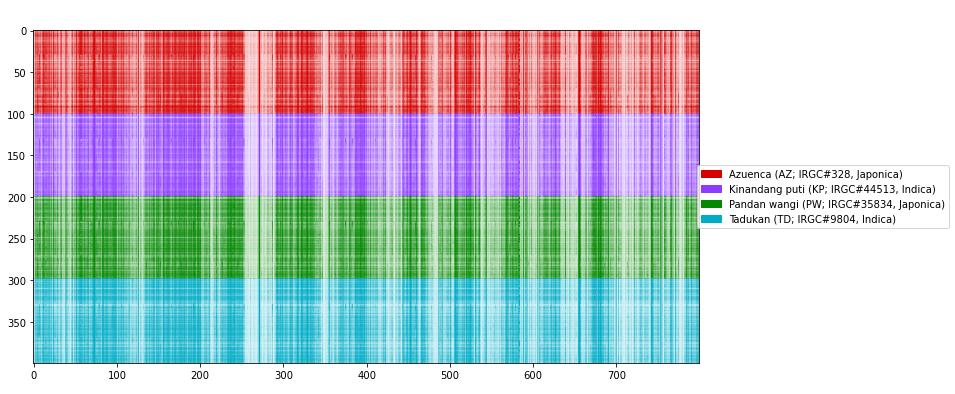

In [16]:
gsf.plots.gem.RasterGEM(dge_collection, hue='genotype')

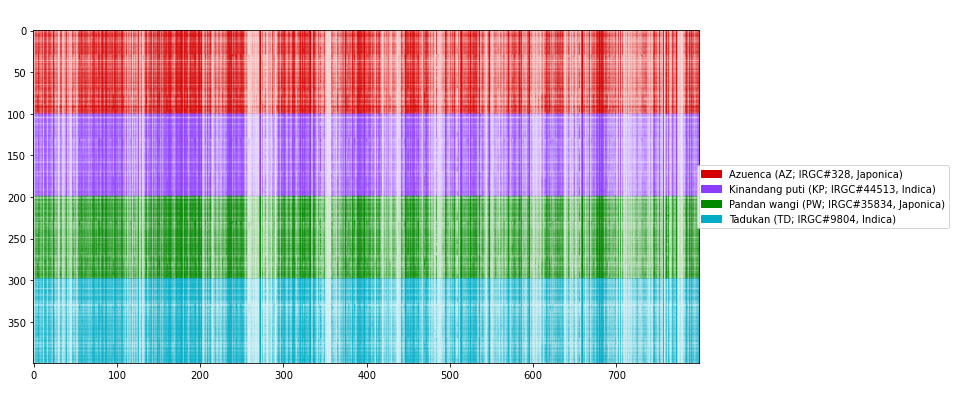

In [17]:
gsf.plots.gem.RasterGEM(dge_collection, selected_gene_sets=['edgeR filter'], hue='genotype')

In [18]:
if not TOUR_DGE.exists():
    dge_collection.save(TOUR_DGE)

### Random Forest via Boruta Feature Selection

See this [FAQ](https://notabug.org/mbq/Boruta/wiki/FAQ) for details on Boruta.

In brief, boruta lets us use a 'minimal optimal' feature selection model as an 'all relevant' method.
Random forest models typically work by finding a minimum optimal set of features.
In our use, we are interested in all features that may be relevant, not the minimum required to train a model.
`GSForge` provides a warpper which returns `xarray.DataSet` objects suitable for immediate `GeneSet` construction.

In [19]:
boruta_gsc = gsf.GeneSetCollection(gem=agem, name='Boruta Results')

selecting_model = RandomForestClassifier(
    class_weight='balanced',
    max_depth=4, 
    n_estimators=100, 
    n_jobs=-1)

for target in ["treatment", "genotype"]:
    boruta_treatment_ds = gsf.operations.BorutaProspector(
        agem,
        estimator=selecting_model,
        annotation_variables=target,
        max_iter=100)
    
    boruta_gsc[f"Boruta_{target}"] = gsf.GeneSet(boruta_treatment_ds, name=f"Boruta_{target}")
    
boruta_gsc

<GSForge.GeneSetCollection>
Boruta Results
GeneSets (2 total): Support Count
    Boruta_treatment: 771
    Boruta_genotype: 663

In [46]:
if not TOUR_BORUTA.exists():
    boruta_gsc.save(TOUR_BORUTA)

We can check if boruta still has features to resolve into important or not by examining the 'support_weak' variable.
In practice one should increase the number of iterations until there are no remaining values to be resolved.

In [20]:
boruta_gsc['Boruta_genotype'].data.support_weak.values.sum()

45

### Gene Sets from Literature

In practice there is often a gene set that is externally defined that we wish to compare.
Fortunately the only requirement for a GeneSet to be useful is that has an index that matches that in our GEM.
See [this notebook](../walkthroughs/oryza_sativa/04-GeneSets_from_Literature) for more details.

Here we read in a supporting information file from the EGRIN study by Wilkins *et. al.*, and after a bit of parsing it is converted to a series of `GeneSet` objects.
This SI table appears to be counts of significant differential expression for time contrasts within each treatment.
The full model is not (exactly) specified in the paper, but we can infer that it was probably:

$$
~ 0 + genotype:treatment:C(time):C(replicate)
$$

Where $C(\text{label})$ indicates treatment as a categorical, rather than scalar variable.
The union for each set of treatment contrasts was probably then used.

In [21]:
si1_df = pd.read_csv(SI_FILE_1_PATH, skiprows=3, index_col=0) 
lit_dge_coll = gsf.GeneSetCollection(gem=agem, name='Literature DGE')

for col in si1_df.columns:
    genes = si1_df[si1_df[col] > 0].index.values
    diff = np.setdiff1d(genes, agem.data.Gene.values)
    if diff.shape[0] > 0:
        print(diff)
    
    lit_dge_coll[col] = gsf.GeneSet.from_gene_array(genes, name=col)

lit_dge_coll.summarize_gene_sets()

{'DROUGHT_UP': 1175,
 'HEAT_UP': 592,
 'RECOV_DROUGHT_UP': 446,
 'DROUGHT_DOWN': 170,
 'HEAT_DOWN': 106,
 'RECOV_HEAT_UP': 76,
 'RECOV_DROUGHT_DOWN': 58,
 'RECOV_HEAT_DOWN': 43}

## 3. Compare Results

While this step is ultimately experiment-specific, it usually entails some combination of:

1. Comparing selected to unselected features by one or more measure.
    + p-values and log-fold-change.
2. Ranking or comparing within a selected set.
    + Random forest feature importance.
    + p-values and log-fold-change.
3. Comparing set memberships, these usually take the form of set operations, such as:
    + union
    + intersection
    + difference
    + unique
4. Comparing between selection sets.
    + Model prediction scores.
    
    
Entries 1 and 2 are typically routine within the same selection set, as the tool used to create that set should provide the needed measures.
More complications emerge with steps 3 and 4, especially when comparing selection sets that derive from different methods.
Without additional wet lab experimentation we are limited in declaring our success in feature identification.
Instead we can score our selected subset as it preforms in prediction models.

For this demonstration we will combine each collection into its own set by taking the union of their selections.
Then we will examine the features selected for all treatments by each method.

In [22]:
union_coll = gsf.GeneSetCollection(gem=agem, name='Combnied Collection')
union_coll.gene_sets.update(boruta_gsc.gene_sets)
lit_geneset = gsf.GeneSet.from_GeneSets(*lit_dge_coll.gene_sets.values(), name='literature_union')
union_coll.gene_sets.update({'literature_union': lit_geneset})

# Here I get the keys for each of the two DGE models we ran above.
dge_keys = pd.Series(dge_collection.gene_sets.keys())
key_sets = [dge_keys[dge_keys.str.startswith(f"'{f}'")].values for f in forumla_designs]

for f, keys in zip(forumla_designs, key_sets):
    name = f"combined '{f}'"
    union_coll[name] = gsf.GeneSet.from_GeneSets(
        *[dge_collection[k] for k in keys],
        name=name)
    
union_coll

<GSForge.GeneSetCollection>
Combnied Collection
GeneSets (5 total): Support Count
    combined '0 + treatment:genotype': 8941
    literature_union: 2061
    Boruta_treatment: 771
    Boruta_genotype: 663
    combined '0 + treatment': 596

### Visualize Set Overlap

See the [upsetplot documentation](https://upsetplot.readthedocs.io/en/stable/) for more details.

Instead of a Venn diagram we use an 'Upset plot'.
This allows us to view overlaps of sets larger than three.

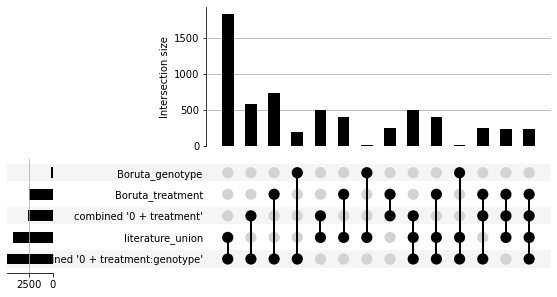

In [23]:
gsf.plots.collections.UpsetPlotInterface(union_coll)

### Comparing Selection Sets

We can estimate how well a given subset of genes 'describes' a sample (phenotype) label by comparing how well they perform using a given machine learning model.

:Bars   [Gene Selection Group]   (y)
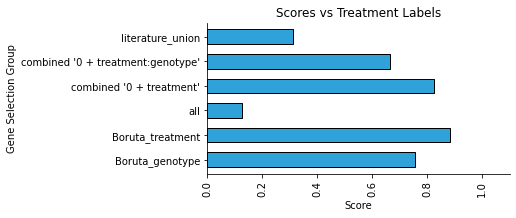

In [24]:
results = dict()

for key in list(union_coll.gene_sets.keys()) + ['all']:
    counts, treatment = gsf.get_gem_data(union_coll, selected_gene_sets=[key], annotation_variables=["treatment"])
    x_train, x_test, y_train, y_test = model_selection.train_test_split(counts, treatment)
    # model = RandomForestClassifier(class_weight='balanced', n_estimators=1000, n_jobs=-1, max_depth=6)
    model = linear_model.Perceptron()
    model.fit(x_train, y_train) 
    results[key] = model.score(x_test, y_test)
    

hv.Bars(results, kdims=["Gene Selection Group"]).opts(
    xrotation=90, invert_axes=True, ylim=(0, 1.1), ylabel='Score', fig_size=150, 
    aspect=2, title='Scores vs Treatment Labels')

### Ranking Features within Sets

GSForge provides helper functions to extract genes by a score values.
Note we get the data from the original dge collection, as those logFC values are intact.

In [25]:
dge_ds = dge_collection["'0 + treatment:genotype'__treatment[HEAT]"]

In [26]:
dge_ds.get_top_n_genes("logFC", 10)

array(['LOC_Os03g14180', 'LOC_Os11g13980', 'LOC_Os04g01740',
       'LOC_Os01g04370', 'LOC_Os01g04360', 'LOC_Os07g47840',
       'LOC_Os02g15930', 'LOC_Os01g04380', 'LOC_Os11g05170',
       'LOC_Os04g36750'], dtype=object)

In [27]:
dge_ds.get_genes_by_threshold(3.0, "logFC")

array(['ChrSy.fgenesh.gene.85', 'ChrSy.fgenesh.gene.86', 'LOC_Os01g01170',
       ..., 'LOC_Os12g43640', 'LOC_Os12g43850', 'LOC_Os12g44250'],
      dtype=object)

### Rank Genes with a Random Forest

Random forests and feature ranks.
Robust enough to function in our case.
Some values filtered prior to dge analysis...

In [28]:
counts.coords.dims[1]

'Gene'

In [29]:
counts.coords[counts.coords.dims[1]].values

array(['ChrSy.fgenesh.gene.21', 'ChrSy.fgenesh.gene.25',
       'ChrSy.fgenesh.gene.28', ..., 'LOC_Os12g44310', 'LOC_Os12g44340',
       'LOC_Os12g44370'], dtype=object)

In [30]:
union_coll["'0 + treatment:genotype'__treatment[HEAT]"] = dge_collection["'0 + treatment:genotype'__treatment[HEAT]"]

gene_rank_mdl = RandomForestClassifier(class_weight='balanced', n_estimators=1000, n_jobs=-2)

treatment_nFDR = gsf.operations.nFDR(
    union_coll,
    selected_gene_sets=["Boruta_treatment", "'0 + treatment:genotype'__treatment[HEAT]"],
    gene_set_mode="union",
    annotation_variables=["treatment"],
    model=gene_rank_mdl,
    n_iterations=5
)

treatment_feature_importance = gsf.operations.RankGenesByModel(
    union_coll,
    selected_gene_sets=["Boruta_treatment", "'0 + treatment:genotype'__treatment[HEAT]"],
    gene_set_mode="union",
    annotation_variables=["treatment"],
    model=gene_rank_mdl,
    n_iterations=5
)

In [32]:
treatment_feature_importance

<xarray.DataArray 'feature_importances' (model_iteration: 5, Gene: 4400)>
array([[9.87587391e-05, 2.78077628e-05, 3.01913826e-04, ...,
        7.66214745e-05, 9.10955089e-05, 2.27226668e-05],
       [2.72735669e-04, 3.35635477e-05, 1.18515353e-04, ...,
        5.42678147e-05, 9.58165323e-05, 4.31426583e-05],
       [2.39190400e-04, 7.20759424e-05, 2.68820846e-04, ...,
        1.20953714e-04, 1.37762978e-04, 3.83793121e-05],
       [1.63639640e-04, 1.04387962e-05, 2.40779121e-04, ...,
        4.94620026e-05, 1.38103627e-04, 4.67529425e-05],
       [8.28568993e-05, 6.16404557e-05, 1.69705913e-04, ...,
        6.60517993e-05, 1.01620259e-04, 6.40308254e-05]])
Coordinates:
  * Gene     (Gene) object 'ChrSy.fgenesh.gene.37' ... 'LOC_Os12g44250'
Dimensions without coordinates: model_iteration
Attributes:
    Ranking Model:         RandomForestClassifier(class_weight='balanced', n_...
    count_variable:        counts
    annotation_variables:  treatment

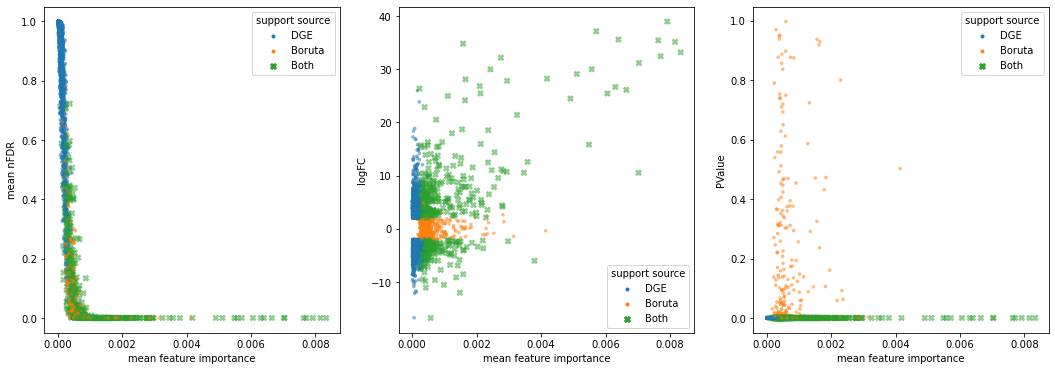

In [34]:
gene_union = union_coll.union(["Boruta_treatment", "'0 + treatment:genotype'__treatment[HEAT]"])

boruta_support = np.isin(gene_union, union_coll["Boruta_treatment"].gene_support())
dge_support = np.isin(gene_union, 
                      union_coll["'0 + treatment:genotype'__treatment[HEAT]"].gene_support())

support = np.zeros_like(gene_union)
support[boruta_support] = "Boruta"
support[dge_support] = "DGE"
support[(boruta_support * dge_support) == True] = "Both"

df = pd.DataFrame({
    "logFC": dge_ds.data['logFC'].reindex(Gene=gene_union).values,
    "PValue": dge_ds.data['PValue'].reindex(Gene=gene_union).values,
#     "F": dge_ds.data['F'].reindex(Gene=gene_union).values,
    "Gene": gene_union,
    "mean feature importance": treatment_feature_importance.mean(dim="model_iteration").values,
    "mean nFDR": treatment_nFDR.mean(dim="model_iteration").values,
    "support source": support,
}).set_index("Gene")

# sns.pairplot(df, hue="support source", markers=['.', '.', 'X'],
#              vars=["mean feature importance", "logFC", "mean nFDR"],
#              plot_kws=dict(edgecolor=None, alpha=0.25));

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.scatterplot(data=df, x='mean feature importance', y='mean nFDR', hue='support source',
                edgecolor=None, alpha=0.5, markers=['.', '.', 'X'], style='support source', ax=axes[0]);
sns.scatterplot(data=df, x='mean feature importance', y='logFC', hue='support source',
                edgecolor=None, alpha=0.5, markers=['.', '.', 'X'], style='support source', ax=axes[1]);
sns.scatterplot(data=df, x='mean feature importance', y='PValue', hue='support source',
                edgecolor=None, alpha=0.5, markers=['.', '.', 'X'], style='support source', ax=axes[2]);

/home/tyler/anaconda3/envs/gsfenv/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


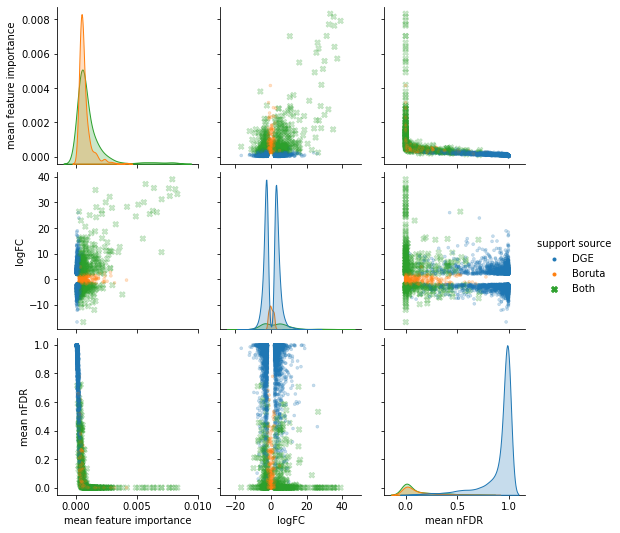

In [36]:
sns.pairplot(df, hue="support source", markers=['.', '.', 'X'],
             vars=["mean feature importance", "logFC", "mean nFDR"],
             plot_kws=dict(edgecolor=None, alpha=0.25));

### UMAP Embeddings of Selections

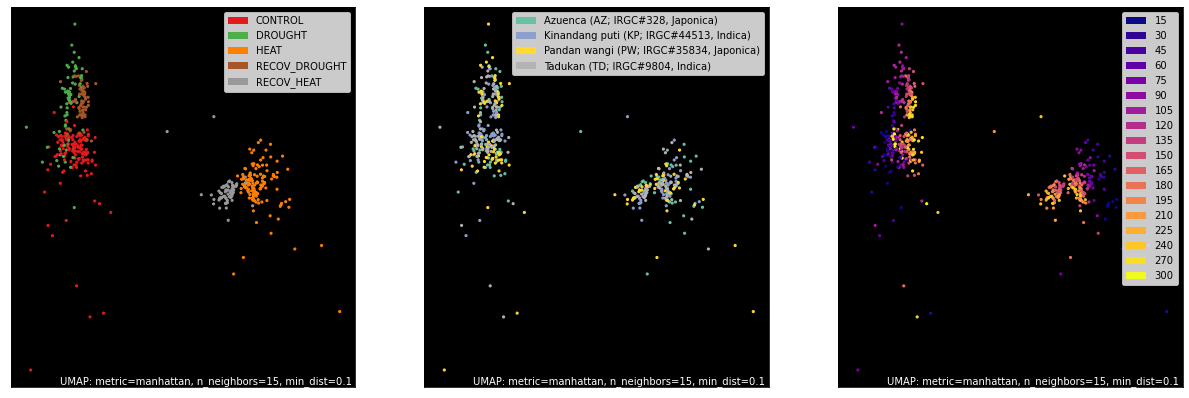

In [37]:
counts, labels = gsf.get_gem_data(union_coll, selected_gene_sets=['Boruta_treatment'], count_variable='qt_counts', 
                                  annotation_variables=['treatment', 'genotype', 'time'])
mapper = umap.UMAP(densmap=True, random_state=50, metric='manhattan').fit(counts.values)
fig, axes = plt.subplots(1, 3, figsize=(21, 7))
umap.plot.points(mapper, labels=labels['treatment'], background='black', ax=axes[0], color_key_cmap='Set1');
umap.plot.points(mapper, labels=labels['genotype'], background='black', ax=axes[1], color_key_cmap='Set2');
umap.plot.points(mapper, labels=labels['time'], background='black', ax=axes[2], color_key_cmap='plasma');

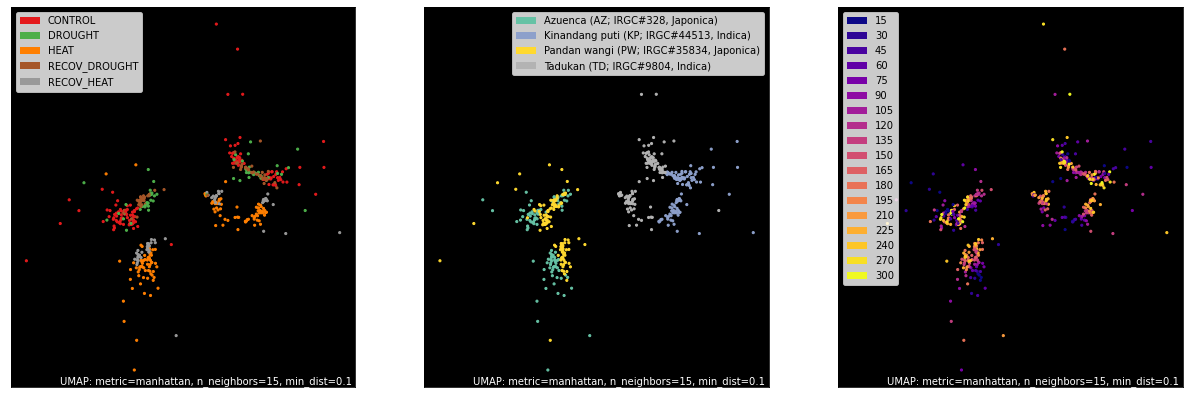

In [38]:
counts, labels = gsf.get_gem_data(union_coll, selected_gene_sets=['literature_union'], count_variable='qt_counts', 
                                  annotation_variables=['treatment', 'genotype', 'time'])
mapper = umap.UMAP(densmap=True, random_state=50, metric='manhattan').fit(counts.values)
fig, axes = plt.subplots(1, 3, figsize=(21, 7))
umap.plot.points(mapper, labels=labels['treatment'], background='black', ax=axes[0], color_key_cmap='Set1');
umap.plot.points(mapper, labels=labels['genotype'], background='black', ax=axes[1], color_key_cmap='Set2');
umap.plot.points(mapper, labels=labels['time'], background='black', ax=axes[2], color_key_cmap='plasma');

### Clustermap Selection

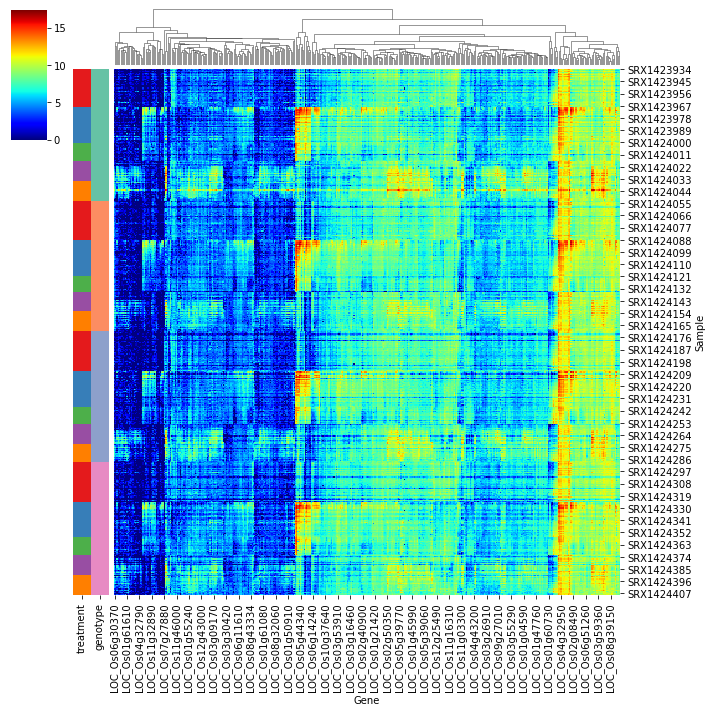

In [39]:
def series_to_colors(series, cmap, categorical=True):
    keys = series.unique()
    colors = hv.plotting.util.process_cmap(cmap, len(keys), categorical=categorical)
    mapper = {k: c for k, c in zip(keys, colors)}
    return series.map(mapper)

# az_samples = agem.data.sel(Sample=agem.data.genotype == 'Azuenca (AZ; IRGC#328, Japonica)')['Sample'].values
df, labels = gsf.get_gem_data(union_coll, 
#                               sample_subset=az_samples, 
                              annotation_variables=['treatment', 'genotype'],
                              selected_gene_sets=["Boruta_treatment", 
                                                  "literature_union"],
                              gene_set_mode='intersection',
                              count_transform=lambda counts: np.log2(counts.where(counts > 0)),
                              output_type="pandas")


color_df = pd.DataFrame({
    "treatment": series_to_colors(labels['treatment'], "Set1"),
    "genotype": series_to_colors(labels['genotype'], "Set2")
})

sns.clustermap(df.fillna(0), 
               metric='cityblock', 
               row_colors=color_df,
               row_cluster=False, 
               dendrogram_ratio=0.1,
               cmap='jet',
               figsize=(10, 10));

### Functional Enrichment / Gene Set Enrichment Analysis

In investigating a set of genes it is common to examine available annotations for those genes. With special interest given to those annotations that appear enriched within our selection.

[GSEAPY](https://gseapy.readthedocs.io/en/latest/index.html) is useful here.

In [40]:
import gseapy as gp
from gseapy.plot import gseaplot

In [41]:
func_data_path = OSF_PATH.joinpath('GEMmakerGEMs', 'raw_annotation_data', 'oryza_sativa.MSU_v7_0.genes2annots.txt')
fdf = pd.read_csv(func_data_path, sep='\t', low_memory=False)
fdf = fdf[fdf['Gene'].isin(agem.data.Gene.values)]
fdf.head()

Gene     Term          Definition        CV Reaction-id  \
0  LOC_Os12g04990  PWY-321  cutin biosynthesis  PlantCyc   RXN-16389   
1  LOC_Os11g35400  PWY-321  cutin biosynthesis  PlantCyc   RXN-16389   
2  LOC_Os05g04170  PWY-321  cutin biosynthesis  PlantCyc   RXN-16389   
3  LOC_Os06g06350  PWY-321  cutin biosynthesis  PlantCyc   RXN-16389   
4  LOC_Os05g25310  PWY-321  cutin biosynthesis  PlantCyc   RXN-16389   

           EC          Protein-id Protein-name     Gene-id  
0  EC-6.2.1.3  GN7F-26073-MONOMER          NaN  GN7F-26073  
1  EC-6.2.1.3  GN7F-17597-MONOMER          NaN  GN7F-17597  
2  EC-6.2.1.3  GN7F-17804-MONOMER          NaN  GN7F-17804  
3  EC-6.2.1.3  GN7F-18230-MONOMER          NaN  GN7F-18230  
4  EC-6.2.1.3  GN7F-26550-MONOMER          NaN  GN7F-26550

In [42]:
support = dge_collection["'0 + treatment'__treatment[HEAT]"].gene_support()
term_counts = fdf.loc[fdf['Gene'].isin(support)].groupby('Term')['Gene'].count()
term_counts = term_counts[term_counts > 10]
scores = dge_collection["'0 + treatment'__treatment[HEAT]"].data['logFC'].sel(Gene=support).to_dataframe()
term_genes = dict()
for term in term_counts.index.values:
    term_genes[term] = fdf.groupby('Term')['Gene'].unique()[term]
    

pre_res = gp.prerank(rnk=scores, 
                     gene_sets=term_genes,
                     processes=4,
                     permutation_num=100, # reduce number to speed up testing
                     outdir='prerank', 
                     format='png', seed=6)

In [43]:
pre_res.res2d.sort_index().head()

es       nes      pval       fdr  geneset_size  \
Term                                                                      
GO:0005524         0.287134  0.933461  0.543210  0.540046          2218   
IPR002068          0.821481  2.909723  0.000000  0.000000            39   
IPR008978          0.793451  2.646324  0.000000  0.000000            50   
expressed protein  0.355513  1.429853  0.106383  0.117277         14309   
path:dosa04141     0.670797  2.644200  0.000000  0.000000           199   

                   matched_size  \
Term                              
GO:0005524                   15   
IPR002068                    17   
IPR008978                    20   
expressed protein            38   
path:dosa04141               27   

                                                               genes  \
Term                                                                   
GO:0005524         LOC_Os04g01740;LOC_Os05g44340;LOC_Os06g12370;L...   
IPR002068          LOC_Os03g14180;LOC_Os11g13980;LOC_Os01g04370;L...   
IPR008978          LOC_Os03g14180;LOC_Os11g13980;LOC_Os01g04370;L...   
expressed protein  LOC_Os07g47840;LOC_Os02g15930;LOC_Os11g05170;L...   
path:dosa04141     LOC_Os03g14180;LOC_Os11g13980;LOC_Os01g04370;L...   

                                                         ledge_genes  
Term                                                                  
GO:0005524              LOC_Os04g01740;LOC_Os05g44340;LOC_Os06g12370  
IPR002068          LOC_Os03g14180;LOC_Os11g13980;LOC_Os01g04370;L...  
IPR008978          LOC_Os03g14180;LOC_Os11g13980;LOC_Os01g04370;L...  
expressed protein  LOC_Os07g47840;LOC_Os02g15930;LOC_Os11g05170;L...  
path:dosa04141     LOC_Os03g14180;LOC_Os11g13980;LOC_Os01g04370;L...

In [44]:
terms = pre_res.res2d.index
terms

Index(['IPR002068', 'IPR008978', 'path:dosa04141', 'expressed protein',
       'GO:0005524'],
      dtype='object', name='Term')

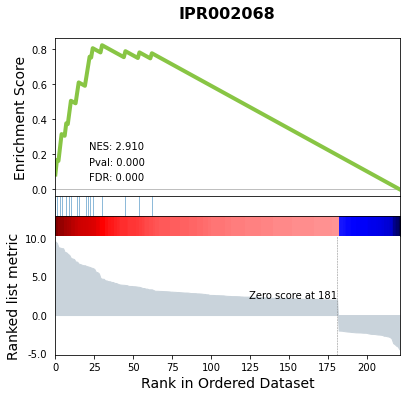

In [45]:
gseaplot(rank_metric=pre_res.ranking, term=terms[0], **pre_res.results[terms[0]])

## Conclusion & Next Steps

Having introduced the `GSForge` package by example we hope you are motivated to compare and share gene selection methodologies. Recall that the scope of gene / feature selection is unique to each experiment, no gold standard method or statistical measure yet exists to unambiguously interpret RNA-seq data. In most cases researchers or their collaborators are interested in a reduced list of genes (rather than the entire genome!) from which to form a hypothesis.

We hope you feel free to contribute, share and question methodologies, and that you find `GSForge` helpful in this endevour.

## References

1. Wilkins, O. et al. EGRINs (Environmental gene regulatory influence networks) in rice that function in the response to water deficit, high temperature, and agricultural environments. Plant Cell 28, 2365–2384 (2016).

2. Ritchie, M. E. et al. Limma powers differential expression analyses for RNA-sequencing and microarray studies. Nucleic Acids Res. 43, e47 (2015).

3. McInnes, L., Healy, J. & Melville, J. UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction. (2018).

4. Lex, A., Gehlenborg, N., Strobelt, H., Vuillemot, R. & Pfister, H. UpSet: Visualization of Intersecting Sets Europe PMC Funders Group. IEEE Trans Vis Comput Graph 20, 1983–1992 (2014).